In [23]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [34]:
def oracle(n, winner='111'):
    
    qc = QuantumCircuit(n, name='oracle')
    
    # initialize identity matrix on n qubits
    oracle_matrix = np.identity(2**n)
    # add phase shift to winner index
    win_idx = int(winner, 2)
    oracle_matrix[win_idx, win_idx] = -1
    
    # convert oracle_matrix into an operator, and add it to the quantum circuit
    qc.unitary(Operator(oracle_matrix), range(n))
    # convert circuit to blackbox gate
    oracle_gate = qc.to_gate()
    oracle_gate.name='oracle'
    
    return oracle_gate

In [33]:
def diffuser(n):
    
    qc = QuantumCircuit(n)
    
    # Apply a H-gate to all qubits (transformation |s> -> |00..0>)
    # Followed by X-gate (transformation |00..0> -> |11..1>)
    for q in range(n):
        qc.h(q)
        qc.x(q)
        
    # Do multi-controlled-Z gate
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli
    qc.h(n-1)
    
    # Apply transformation |11..1> -> |00..0>
    # Apply transformation |00..0> -> |s>
    for q in range(n):
        qc.x(q)
        qc.h(q)

    # Convert diffuser to gate
    diff_gate = qc.to_gate()
    diff_gate.name = "diffuser"
    
    return diff_gate

In [40]:
def grover_circuit(n, winner):
    
    qc = QuantumCircuit(n,n)
    
    # Apply a H-gate to all qubits
    for q in range(n):
        qc.h(q)

    # add oracle
    qc.append(oracle(n, winner), range(n))
    
    # add diffuser
    qc.append(diffuser(n), range(n))
    
     # step 3: measure all qubits
    qc.measure(range(n), range(n))
  
    return qc
 

In [41]:
n = 4
winner = '1101'
grover_qc = grover_circuit(n, winner)
grover_qc.draw()

┌───┐┌─────────┐┌───────────┐┌─┐         
q_0: ┤ H ├┤0        ├┤0          ├┤M├─────────
     ├───┤│         ││           │└╥┘┌─┐      
q_1: ┤ H ├┤1        ├┤1          ├─╫─┤M├──────
     ├───┤│  oracle ││  diffuser │ ║ └╥┘┌─┐   
q_2: ┤ H ├┤2        ├┤2          ├─╫──╫─┤M├───
     ├───┤│         ││           │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├┤3        ├┤3          ├─╫──╫──╫─┤M├
     └───┘└─────────┘└───────────┘ ║  ║  ║ └╥┘
c: 4/══════════════════════════════╩══╩══╩══╩═
                                   0  1  2  3

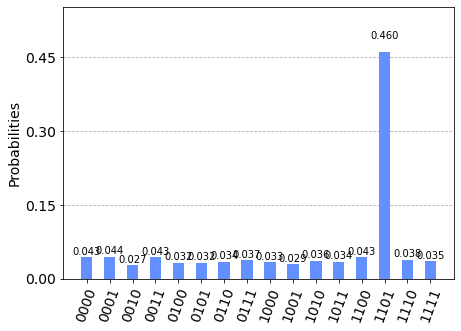

In [42]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(grover_qc, backend=simulator, shots=1000).result().get_counts(grover_qc)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [5]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw()

┌───┐   
q_0: ┤ H ├─■─
     ├───┤ │ 
q_1: ┤ H ├─■─
     └───┘

In [6]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

┌───┐   ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ │ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     └───┘   └───┘└───┘   └───┘

In [7]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(grover_circuit)
result = sv_sim.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>